In [1]:
# Install the required libraries: Run this in your terminal:
! pip install tensorflow scikit-learn

In [2]:
! pip install tensorflow scikit-learn matplotlib pandas

Epoch 1/10


C:\Users\hanss\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0157
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0027
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0019
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0013
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.4524e-04
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1

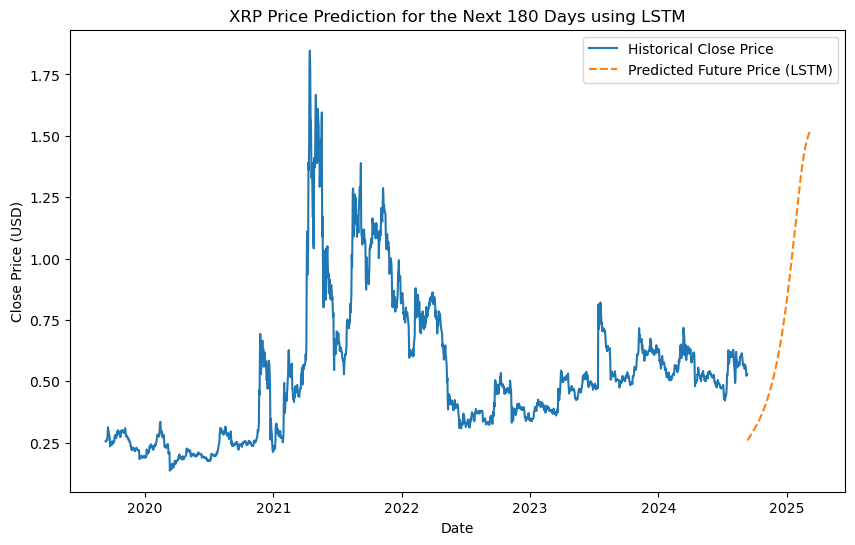

In [3]:
# LSTM Model Implementation: You can use the following code to train the LSTM model and predict the next 180 days of XRP prices.

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load your data (replace with your own data if necessary)
xrp_data = pd.read_csv('ripple_2019-09-11_2024-09-09.csv')

# Use the 'End' column as the date
xrp_data['End'] = pd.to_datetime(xrp_data['End'])
close_price = xrp_data['Close'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.reshape(-1, 1))

# Prepare the data for the LSTM model
def create_lstm_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # We use 60 days of historical data to predict the next price
X_train, y_train = create_lstm_dataset(scaled_data, time_step)

# Reshape the input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

# Prepare test data (the last 60 days of data)
test_data = scaled_data[-time_step:]
X_test = []
X_test.append(test_data)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the next 180 days
predicted_prices = []
for _ in range(180):  # Change 30 to 180 for a 180-day prediction
    prediction = model.predict(X_test)
    predicted_prices.append(prediction[0, 0])

    # Reshape the prediction to match the dimensions of X_test before appending
    prediction_reshaped = np.reshape(prediction[0, 0], (1, 1, 1))
    X_test = np.append(X_test[:, 1:, :], prediction_reshaped, axis=1)

# Rescale the predicted prices back to the original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Create future dates for the predictions
future_dates = pd.date_range(xrp_data['End'].max(), periods=180, freq='D')  # Extend to 180 days

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(xrp_data['End'], close_price, label='Historical Close Price')
plt.plot(future_dates, predicted_prices, label='Predicted Future Price (LSTM)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('XRP Price Prediction for the Next 180 Days using LSTM')
plt.legend()
plt.show()
